### Computation of the fundamental dipole (quark scattering matrix) in the configuration and the momentum space. Computation of the ratio $g^2 \mu/Q_s$.

In [18]:
# Import our functions
import cgc

# Import numpy and matplotlib for plotting/other utility
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Make our plots nice and large
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 12

In [23]:
M = 10 #Number of configurations  
N = 256  
L = 32 # S_\perp = L^2 is the area of the target
delta = L/N 
mu = 1 # defines the units in the calculation 

# Collecting and storing configurations; here the fundamental Wilson line in x space are stored
# This step may take about 20-30 minutes 
V_list=[]
for m in range(M):
    print('Configuration #', m , ' ', '.'*10)
    nucleus = cgc.Nucleus(3, N, delta,  mu,  M=0.1, Ny=100)
    V=nucleus.wilsonLine(verbose=1)
    V_list.append(V) 
    print('Configuration #', m , ' ', '.'*10, ' finished!') 

Configuration # 0   ..........
Generating Nucleus color charge field..........finished!
Calculating Nucleus gauge field..........finished!
Calculating Nucleus wilson line..........finished!
Configuration # 0   ..........  finished!
Configuration # 1   ..........
Generating Nucleus color charge field..........finished!
Calculating Nucleus gauge field..........finished!
Calculating Nucleus wilson line..........finished!
Configuration # 1   ..........  finished!
Configuration # 2   ..........
Generating Nucleus color charge field..........finished!
Calculating Nucleus gauge field..........finished!
Calculating Nucleus wilson line..........finished!
Configuration # 2   ..........  finished!
Configuration # 3   ..........
Generating Nucleus color charge field..........finished!
Calculating Nucleus gauge field..........finished!
Calculating Nucleus wilson line..........finished!
Configuration # 3   ..........  finished!
Configuration # 4   ..........
Generating Nucleus color charge field....

In [60]:
# Evaluating the S matrix in momentum and configuration spaces  
import scipy


def Scattering_matrix(V_list):
    S=np.zeros([N, N],dtype='complex')
    S_fft=np.zeros([N, N],dtype='complex')
    
    M=len(V_list)
    
    for V in V_list: 
        for j in range(3):
            for n in range(3):
                V_fft=scipy.fft.fft2(V,axes=(0,1),workers=-1) 
    
        for kx in range(N):
            for ky in range(N):
                S_fft[kx,ky] += np.trace (V_fft[kx,ky]@np.conjugate(np.transpose(V_fft[kx,ky])))

    S_fft = S_fft/(3.0*M)
    S = scipy.fft.ifft2(S_fft,norm=None)/N**2
    return (S,delta**4*S_fft/L**2)

S,S_fft = Scattering_matrix(V_list)

In [111]:
# binning and defining the ratio g^2 mu/Qs via S( g^2 \mu r_s )   = e^{-1/2} with Q_s r_s = sqrt(2)
# or Q_s/(g^2 \mu)   (r_s g^2 \mu) = sqrt(2) thus  g^2 \mu/Q_s = 1/sqrt(2)  (r_s g^2 \mu) 
S_b = np.zeros(int(N/2),dtype='float')
n_b = np.zeros(int(N/2),dtype='float')

for n in range(N):
    for l in range(N):
        rx = n*delta
        ry = l*delta
        r = np.sqrt(rx**2+ry**2)
        r_bin=int(r/delta)
        if  r_bin<N/2:
            S_b[r_bin] = S_b[r_bin]  + S[n,l].real
            n_b[r_bin] = n_b[r_bin]  + 1

            
S_b=S_b/n_b # normalization
from scipy import interpolate
r = delta*(np.arange(int(N/2))+0.5)
tck = interpolate.splrep(r,S_b-np.exp(-0.5), s=0)
muOverQs=(interpolate.sproot(tck)/np.sqrt(2))[0]
print('g^2 mu/Qs =',muOverQs)
# Ref https://arxiv.org/pdf/1411.6630.pdf above eq 12,  provides g^2 mu/Qs = 1/0.7125 = 1.403508772
# which is close to the result; the difference of 12% is due to the finer lattice in 1411.6630 

g^2 mu/Qs = 1.5740298392387095


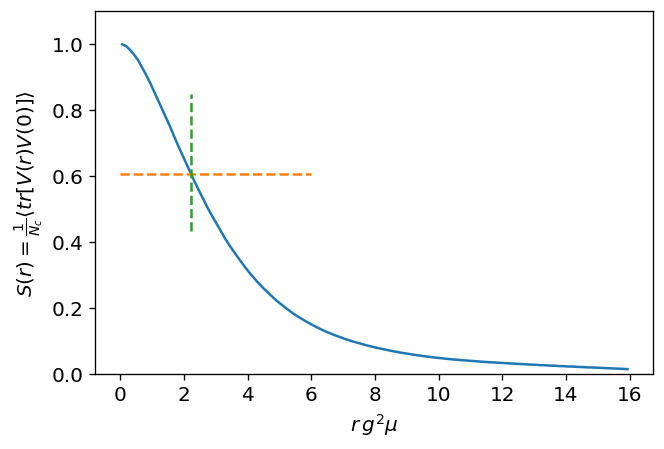

In [112]:
# The fuindamental dipole S(r) in the coordinate space
plt.plot(r,S_b)
plt.plot([0,6],[np.exp(-0.5),np.exp(-0.5)],'--')
plt.plot([muOverQs*np.sqrt(2),muOverQs*np.sqrt(2)],[np.exp(-0.5)/1.4,np.exp(-0.5)*1.4],'--')

plt.ylim(0,1.1)
plt.xlabel(r'$r \, g^2 \mu$')
plt.ylabel(r'$S(r) = \frac{1}{N_c} \langle tr [V(r) V(0)] \rangle $');

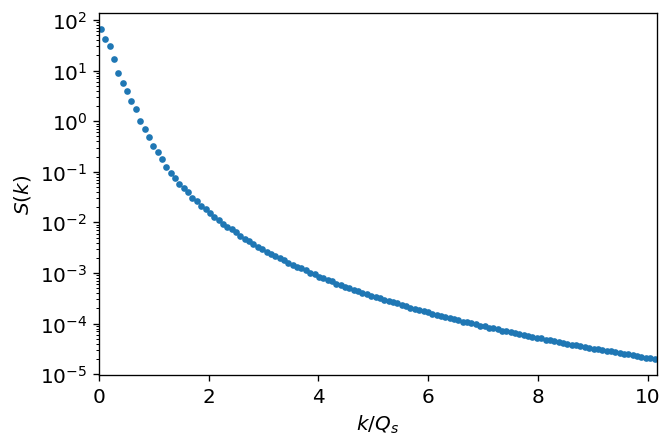

In [121]:
# Scattering matrix in momentum space 
Sfft_b = np.zeros(int(N/2),dtype='float')
n_b = np.zeros(int(N/2),dtype='float')+1e-12

deltak = 2.0/delta / (N/2) # maximum momentum = 2.0/delta; N/2 bins 

for n in range(N):
    for l in range(N):
        kx = 2.0/delta*np.sin(np.pi*n/N)
        ky = 2.0/delta*np.sin(np.pi*l/N)
        k = np.sqrt(kx**2+ky**2)
        k_bin=int(k/deltak)
        if  k_bin<int(N/2):
            Sfft_b[k_bin] = Sfft_b[k_bin]  + S_fft[n,l].real
            n_b[k_bin] = n_b[k_bin]  + 1

Sfft_b=Sfft_b/n_b # divide by the number of counts in the bin 

k = deltak*(np.arange(int(N/2))+0.5)
plt.plot(k/muOverQs,Sfft_b,'.')

plt.yscale('log')
plt.xlim(0,2/delta/muOverQs)
#plt.ylim(1e-3,100)
plt.xlabel(r'$k/Q_s$')
plt.ylabel(r'$S(k)$');